In [29]:
import pandas as pd

# Path to the final enriched database
CHRONICLE_DB_PATH = r"D:\Development\RESEARCH\urban_flood_database\chronicle\imerg_rain_outputs\chronicle_urban_df_with_IMERG_FULL.pkl"

# Load the DataFrame
df_chronicle = pd.read_pickle(CHRONICLE_DB_PATH)
df_chronicle.shape

(29410, 22)

In [30]:
df_chronicle

,Unnamed: 0,uuid,area_km2,version,start_time,end_time,duration_days,geometry_wkt,urban_built_up_area_m2,polygon_total_area_m2,...,poly_area_km2,upa_max,upa_p95,upa_p99,PFDI_p95,PFDI_p99,PFDI_max,imerg_matrix,imerg_mask,imerg_meta
0,296,1422c1c0986549d7a3c7d10a09208098,18.198011,v3.1,2000-06-01,9.598176e+08,1,"POLYGON ((-98.923354 19.259108, -98.916374 19....",6055133.0,1.790232e+07,...,17.807278,7775.601562,37.711626,7437.391806,2.117765,417.660235,436.653018,"[[[0.0, 0.0]], [[0.0, 0.0]], [[0.0, 0.0]], [[0...","[[1, 0]]","{'origin_top_left': (19.288329, -98.923354), '..."
1,297,43553235080041299c3e48978885c635,38.654336,v3.1,2000-06-01,9.598176e+08,1,"POLYGON ((-98.953929 19.329468, -98.883774 19....",8815066.0,2.984955e+07,...,29.694248,7266.895020,0.360294,42.387838,0.012133,1.427476,244.723996,"[[[0.33306354, 0.0024441965], [0.0, 0.0]], [[0...","[[1, 0], [0, 0]]","{'origin_top_left': (19.346044, -98.953929), '..."
2,298,6532dc29aaa645239f52ad164489e0aa,1678.933557,v3.1,2000-06-01,9.598176e+08,1,"POLYGON ((95.067367 28.023449, 95.288819 28.09...",6223800.0,1.760002e+09,...,1754.314154,255259.687500,1.637564,1.637564,0.000933,0.000933,145.503978,"[[[0.0, 0.39326465, 1.6282946, 0.2216488, 0.23...","[[0, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 0], [1, 1...","{'origin_top_left': (28.320151, 95.067367), 's..."
3,299,bd7267cb286448798c31cfab0f6a0f95,28.562733,v3.1,2000-06-01,9.598176e+08,1,"POLYGON ((-98.97432499999999 19.337026, -98.93...",3757833.0,1.180029e+07,...,11.730829,8171.314453,0.613581,0.613581,0.052305,0.052305,696.567534,"[[[0.33306354], [0.0]], [[0.5504179], [0.0]], ...","[[1], [0]]","{'origin_top_left': (19.337026, -98.974325), '..."
4,300,d2205ca5dd1c42f2b6ca67ab9bf1e9e8,117.791321,v3.1,2000-06-01,9.598176e+08,1,"POLYGON ((1.3503293 43.604335, 1.4399303 43.66...",28337179.0,1.056523e+08,...,105.597815,10537.763672,0.304269,648.954102,0.002881,6.145526,99.791494,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]], [[0.0, 0....","[[1, 1, 0], [1, 1, 0]]","{'origin_top_left': (43.668714, 1.3503293), 's..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29495,29791,024af9e92e3b4c0393a0427bad313a85,0.719114,v3.1,2010-05-16,1.273968e+09,1,"POLYGON ((21.935229 44.910029, 21.949369 44.89...",111406.0,7.859925e+05,...,0.785934,20.916019,20.200990,20.820681,25.703156,26.491633,26.612940,"[[[0.0], [0.026895352]], [[0.0], [0.0]], [[0.0...","[[1], [0]]","{'origin_top_left': (44.910029, 21.935229), 's..."
29496,29792,037daffd9d63447a89ead87587d67534,97.242064,v3.1,2010-05-16,1.274054e+09,2,"POLYGON ((16.527098 47.263659, 16.684477 47.27...",6915554.0,1.080988e+08,...,108.169092,374.948700,2.816818,135.496496,0.026041,1.252636,3.466320,"[[[0.0, 0.0], [0.0, 0.0]], [[0.0, 0.0], [0.0, ...","[[1, 1], [1, 1]]","{'origin_top_left': (47.270295, 16.527098), 's..."
29497,29793,0300af350ec444d382b33c33f995c4a9,102.395090,v3.1,2010-05-16,1.273968e+09,1,"POLYGON ((18.996203 48.741874, 19.102049 48.80...",5942608.0,1.398367e+08,...,139.950110,1843.942749,0.137421,146.812248,0.000982,1.049033,13.175715,"[[[0.13440298, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0,...","[[1, 1, 1, 0], [0, 1, 0, 0], [0, 0, 0, 0]]","{'origin_top_left': (48.804063, 18.996203), 's..."
29498,29794,463baf7df0824949ac180823d5ed90dd,20.001648,v3.1,2010-05-16,1.274054e+09,2,"POLYGON ((20.694821 48.446464, 20.726886 48.48...",227431.0,2.200467e+07,...,22.020171,1515.697021,0.093398,1269.703699,0.004241,57.660936,68.832208,"[[[0.0017501651, 0.0023571525, 0.0021689783]],...","[[1, 1, 0]]","{'origin_top_left': (48.485079, 20.694821), 's..."


In [31]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# ============================================
# CONFIGURATION
# ============================================

# Define the durations (in minutes) for intensity calculation
# Base resolution is 30 min
DURATIONS = [30, 60, 120, 240, 360, 720, 1440]

print(f"Starting Intensity Analysis for {len(df_chronicle)} events...")

# List to store result dictionaries
results_list = []

# ============================================
# CALCULATION LOOP
# ============================================

for idx, row in tqdm(df_chronicle.iterrows(), total=len(df_chronicle)):
    
    # Extract Matrix and Mask
    matrix = row['imerg_matrix'] # Shape: (Time, Y, X)
    mask = row['imerg_mask']     # Shape: (Y, X)
    
    # --- VALIDATION ---
    # Skip if matrix is None or empty
    if not isinstance(matrix, np.ndarray) or matrix.size == 0:
        continue
        
    # Skip if mask has no valid pixels
    if mask.sum() == 0:
        continue

    # --- STEP 1: SPATIAL AVERAGE ---
    # Collapse spatial dimensions: (Time, Y, X) -> (Time,)
    # Select pixels where mask == 1 and take the mean across spatial dimensions
    # Result is a 1D array representing the basin-averaged hyetograph (mm/hr)
    valid_pixels = matrix[:, mask == 1]
    hyetograph_series = np.nanmean(valid_pixels, axis=1)
    
    # Convert to pandas Series for rolling window calculations
    ts_series = pd.Series(hyetograph_series)

    # Initialize result dictionary for this event
    event_stats = {'event_id': row['event_id']}
    
    # --- STEP 2: TEMPORAL ROLLING MAX ---
    for minutes in DURATIONS:
        # Calculate window size in time steps (IMERG is 30 min resolution)
        # e.g., 60 min duration = 2 steps
        window_size = int(minutes / 30)
        
        # Check if the time series is long enough for this window
        if len(ts_series) >= window_size:
            # Calculate rolling MEAN to get intensity (mm/hr) over the window
            # Then take the MAX value to find peak intensity
            max_intensity = ts_series.rolling(window=window_size).mean().max()
        else:
            max_intensity = np.nan # Time series too short for this duration
            
        # Add to dictionary: e.g., '60_max_rainfall_intens'
        col_name = f"{minutes}_max_rainfall_intens"
        event_stats[col_name] = max_intensity
        
    results_list.append(event_stats)

# ============================================
# MERGE RESULTS
# ============================================

# Convert results to DataFrame
df_intensities = pd.DataFrame(results_list)

print(f"Calculated intensities for {len(df_intensities)} events.")

# Merge back to the main dataframe
# We use 'left' join to keep all original rows, filling NaNs where calculation failed
df_chronicle_intensities = df_chronicle.merge(df_intensities, on='event_id', how='left')

# Display sample of the new columns
cols_to_show = ['event_id'] + [f"{d}_max_rainfall_intens" for d in DURATIONS]
print("\n--- Sample Results (df_chronicle_intensities) ---")
print(df_chronicle_intensities[cols_to_show].head())

Starting Intensity Analysis for 29410 events...


100%|███████████████████████████████████████████████████████████████████████████| 29410/29410 [00:47<00:00, 617.56it/s]


Calculated intensities for 29407 events.

--- Sample Results (df_chronicle_intensities) ---
   event_id  30_max_rainfall_intens  60_max_rainfall_intens  \
0       296                4.568446                4.568446   
1       297                5.905882                5.328168   
2       298                1.239642                0.898038   
3       299                5.905882                5.328168   
4       300               20.037289               15.327168   

   120_max_rainfall_intens  240_max_rainfall_intens  360_max_rainfall_intens  \
0                 3.679287                 2.567239                 1.828248   
1                 4.617779                 3.525245                 2.631945   
2                 0.698607                 0.636494                 0.466378   
3                 4.617779                 3.525245                 2.631945   
4                 9.840519                 4.920259                 3.280173   

   720_max_rainfall_intens  1440_max_rainfall_in

In [27]:
df_chronicle_intensities

,Unnamed: 0,uuid,area_km2,version,start_time,end_time,duration_days,geometry_wkt,urban_built_up_area_m2,polygon_total_area_m2,...,imerg_matrix,imerg_mask,imerg_meta,30_max_rainfall_intens,60_max_rainfall_intens,120_max_rainfall_intens,240_max_rainfall_intens,360_max_rainfall_intens,720_max_rainfall_intens,1440_max_rainfall_intens
0,296,1422c1c0986549d7a3c7d10a09208098,18.198011,v3.1,2000-06-01,9.598176e+08,1,"POLYGON ((-98.923354 19.259108, -98.916374 19....",6055133.0,1.790232e+07,...,"[[[0.0, 0.0]], [[0.0, 0.0]], [[0.0, 0.0]], [[0...","[[1, 0]]","{'origin_top_left': (19.288329, -98.923354), '...",4.568446,4.568446,3.679287,2.567239,1.828248,1.171332,0.742607
1,297,43553235080041299c3e48978885c635,38.654336,v3.1,2000-06-01,9.598176e+08,1,"POLYGON ((-98.953929 19.329468, -98.883774 19....",8815066.0,2.984955e+07,...,"[[[0.33306354, 0.0024441965], [0.0, 0.0]], [[0...","[[1, 0], [0, 0]]","{'origin_top_left': (19.346044, -98.953929), '...",5.905882,5.328168,4.617779,3.525245,2.631945,1.408315,0.844070
2,298,6532dc29aaa645239f52ad164489e0aa,1678.933557,v3.1,2000-06-01,9.598176e+08,1,"POLYGON ((95.067367 28.023449, 95.288819 28.09...",6223800.0,1.760002e+09,...,"[[[0.0, 0.39326465, 1.6282946, 0.2216488, 0.23...","[[0, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 0], [1, 1...","{'origin_top_left': (28.320151, 95.067367), 's...",1.239642,0.898038,0.698607,0.636494,0.466378,0.268521,0.134261
3,299,bd7267cb286448798c31cfab0f6a0f95,28.562733,v3.1,2000-06-01,9.598176e+08,1,"POLYGON ((-98.97432499999999 19.337026, -98.93...",3757833.0,1.180029e+07,...,"[[[0.33306354], [0.0]], [[0.5504179], [0.0]], ...","[[1], [0]]","{'origin_top_left': (19.337026, -98.974325), '...",5.905882,5.328168,4.617779,3.525245,2.631945,1.408315,0.844070
4,300,d2205ca5dd1c42f2b6ca67ab9bf1e9e8,117.791321,v3.1,2000-06-01,9.598176e+08,1,"POLYGON ((1.3503293 43.604335, 1.4399303 43.66...",28337179.0,1.056523e+08,...,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]], [[0.0, 0....","[[1, 1, 0], [1, 1, 0]]","{'origin_top_left': (43.668714, 1.3503293), 's...",20.037289,15.327168,9.840519,4.920259,3.280173,1.640086,0.820043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4471,4775,5aba612d5b764d70979981a4e68d75eb,383.006111,v3.1,2003-09-02,1.062461e+09,1,"POLYGON ((128.1603 35.656628, 128.16798 35.814...",9184650.0,4.359516e+08,...,"[[[0.05225966, 0.039783534, 0.06782482, 0.0716...","[[1, 1, 1, 1], [1, 1, 1, 0], [0, 1, 1, 0]]","{'origin_top_left': (35.829923, 128.1603), 'sc...",5.311942,4.702203,4.482821,4.107513,2.908465,1.470261,0.740704
4472,4776,0b1d0d93b99d484b9f2124d0313a1209,84.785781,v3.1,2003-09-02,1.062461e+09,1,"MULTIPOLYGON (((129.36324 35.737693, 129.36329...",401885.0,3.418764e+07,...,"[[[0.054847445, 0.08540621], [0.0, 0.075555086...","[[1, 1], [0, 0]]","{'origin_top_left': (35.738242, 129.36324), 's...",8.769548,6.255831,5.031700,2.922197,1.949603,0.974801,0.487727
4473,4781,675d7ff97e454c70b3cc5f0494cae094,613.641702,v3.1,2003-09-02,1.062461e+09,1,"POLYGON ((128.04668 35.932469, 128.28329 36.04...",13277723.0,5.870168e+08,...,"[[[0.01696729, 0.010224658, 0.020268314, 0.022...","[[1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1, 1], [0,...","{'origin_top_left': (36.046787, 128.04668), 's...",5.916342,5.612350,5.306022,4.290368,3.026823,1.525955,0.768409
4474,4782,c682f22394f44e5ebc431557cc34a7ee,1319.083731,v3.1,2003-09-02,1.062461e+09,1,"MULTIPOLYGON (((128.97073 35.754672, 129.02642...",40328318.0,1.305342e+09,...,"[[[0.0, 0.0, 0.011460508, 0.24171408, 0.305302...","[[0, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 0, 0, 0],...","{'origin_top_left': (36.079426, 128.97073), 's...",5.746487,4.472024,3.738039,2.276691,1.634883,0.852345,0.434132


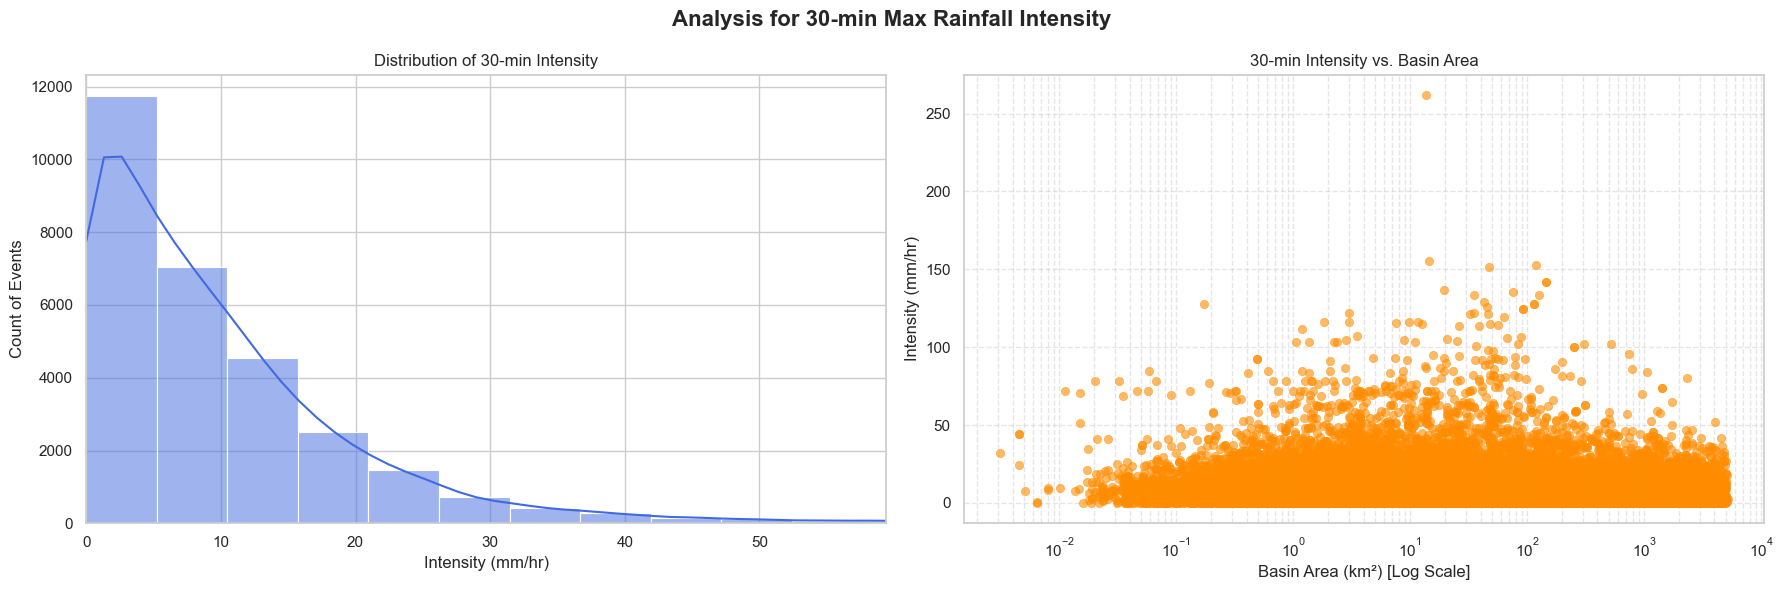

--------------------------------------------------------------------------------


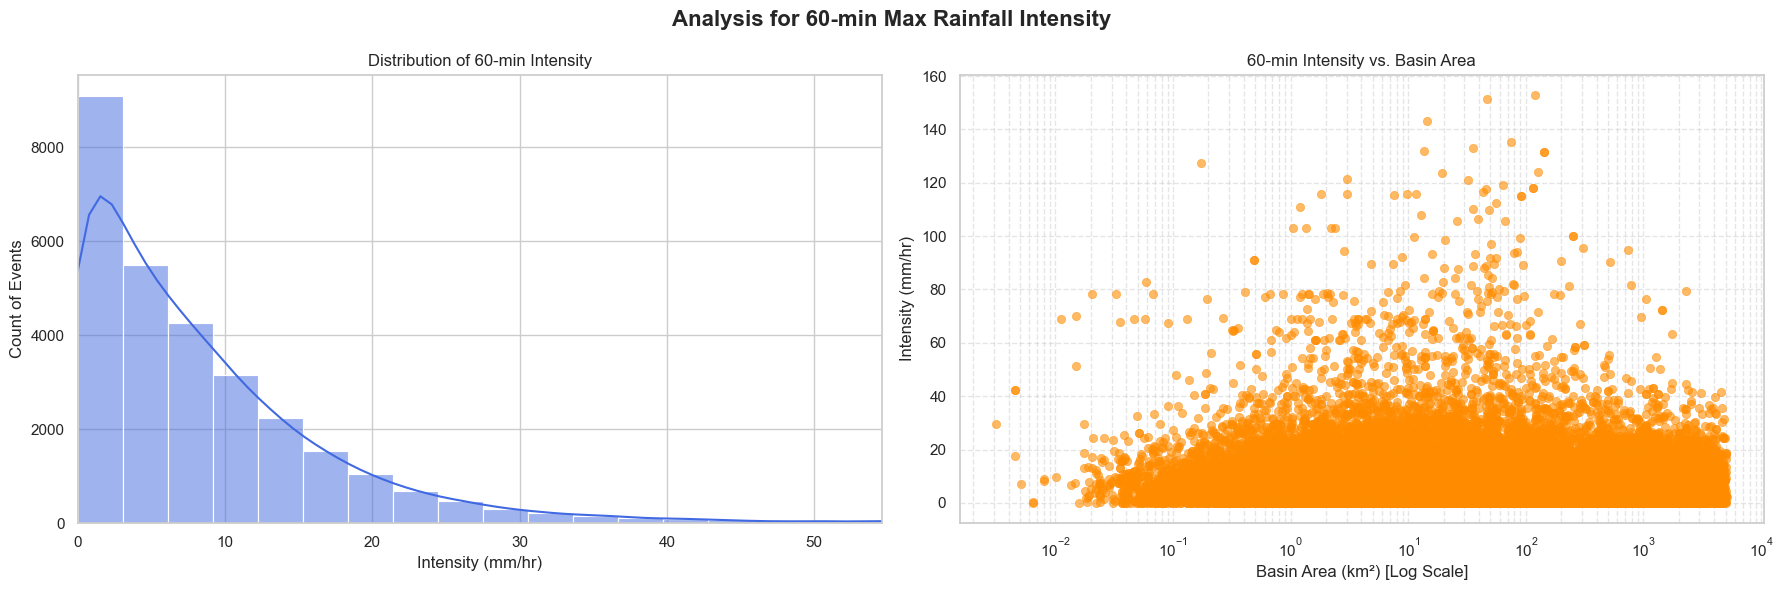

--------------------------------------------------------------------------------


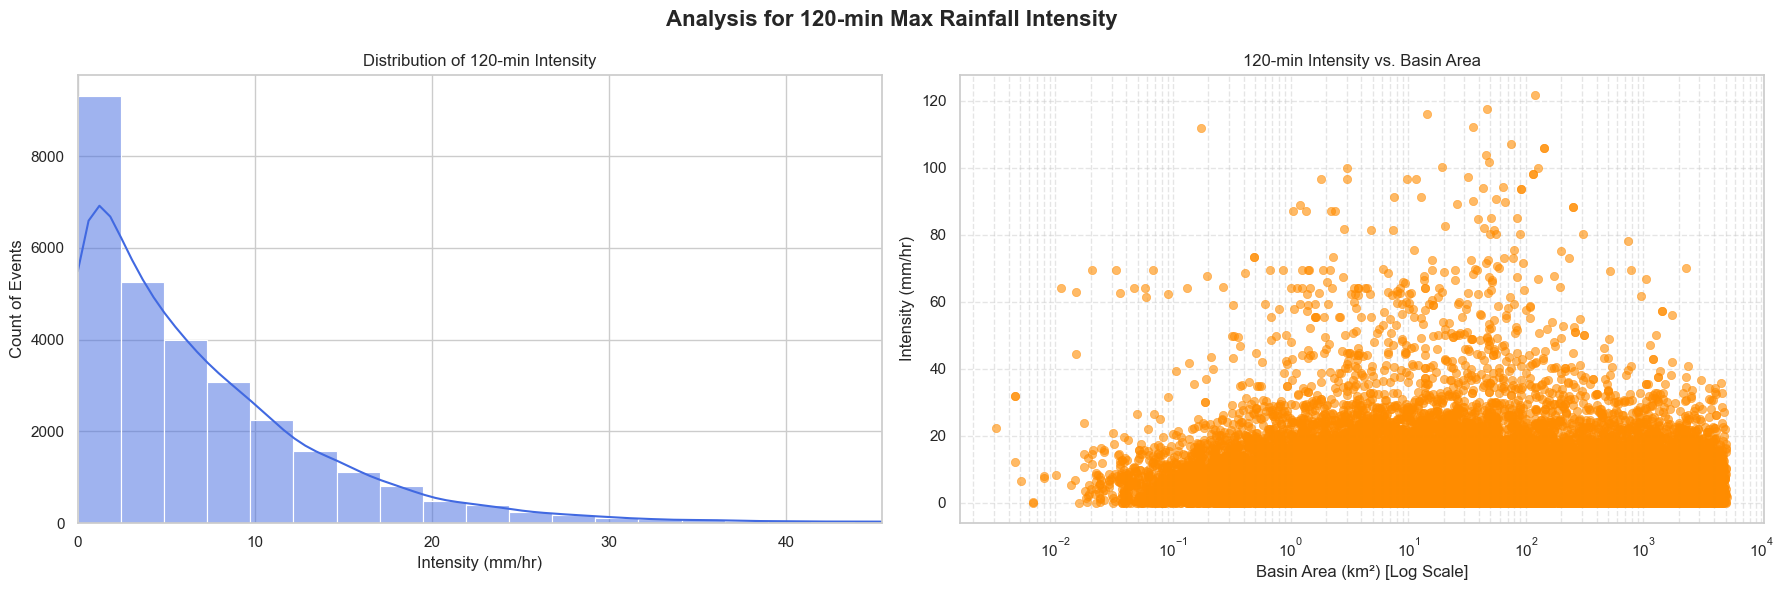

--------------------------------------------------------------------------------


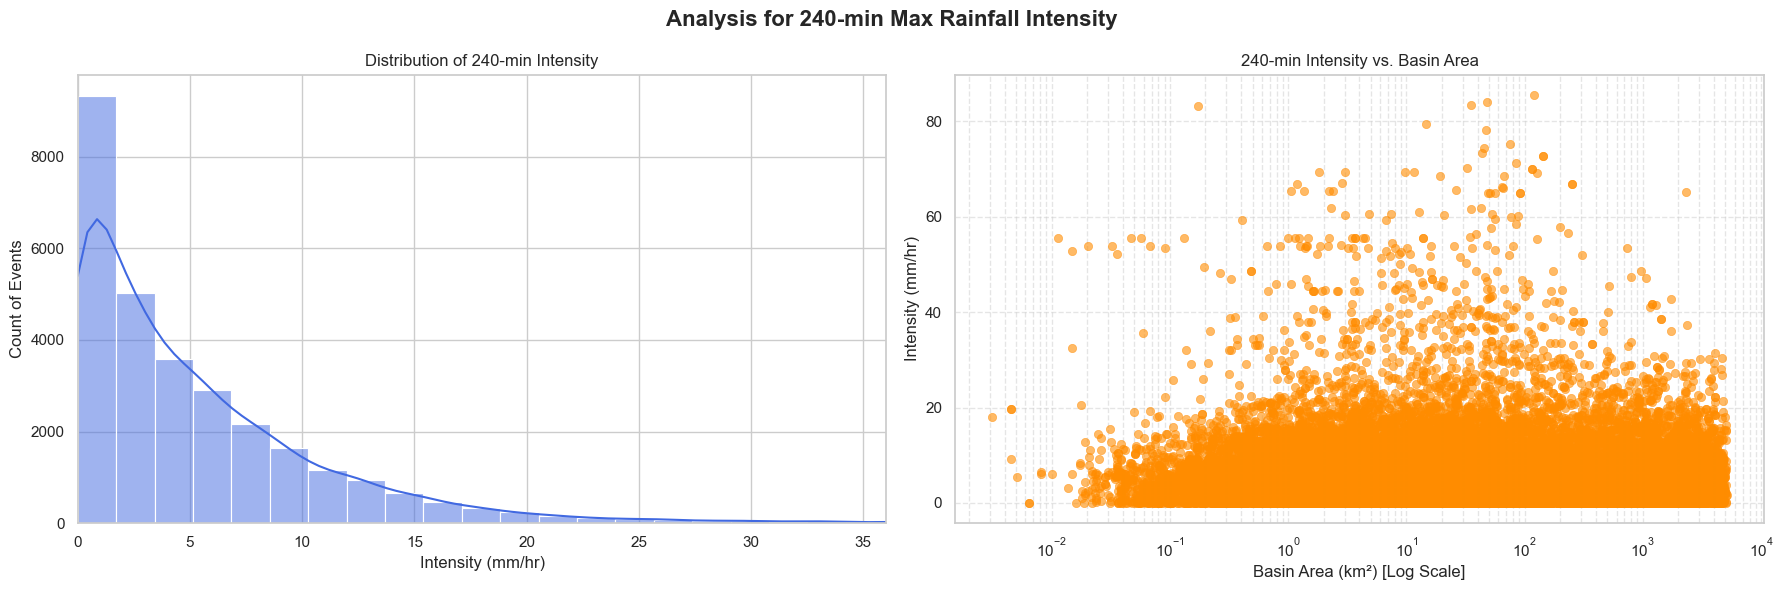

--------------------------------------------------------------------------------


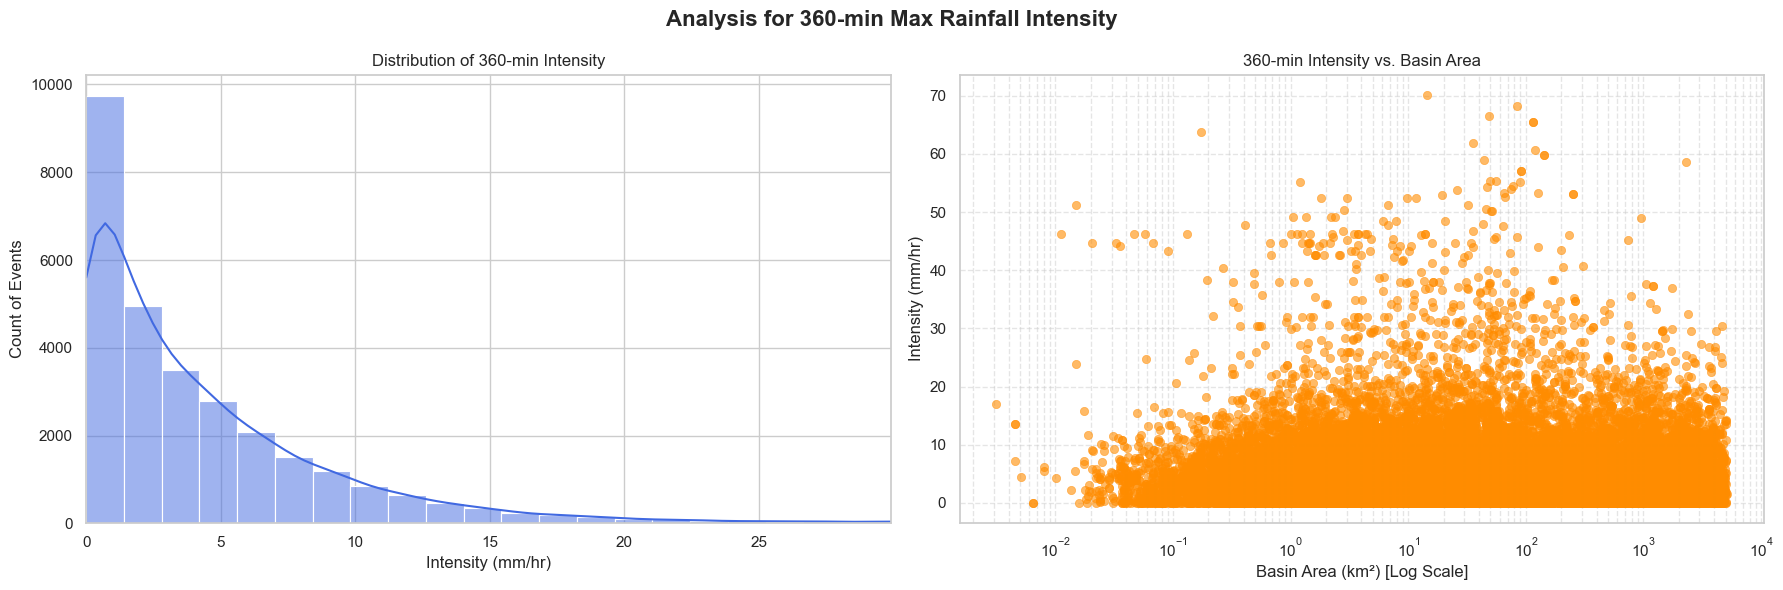

--------------------------------------------------------------------------------


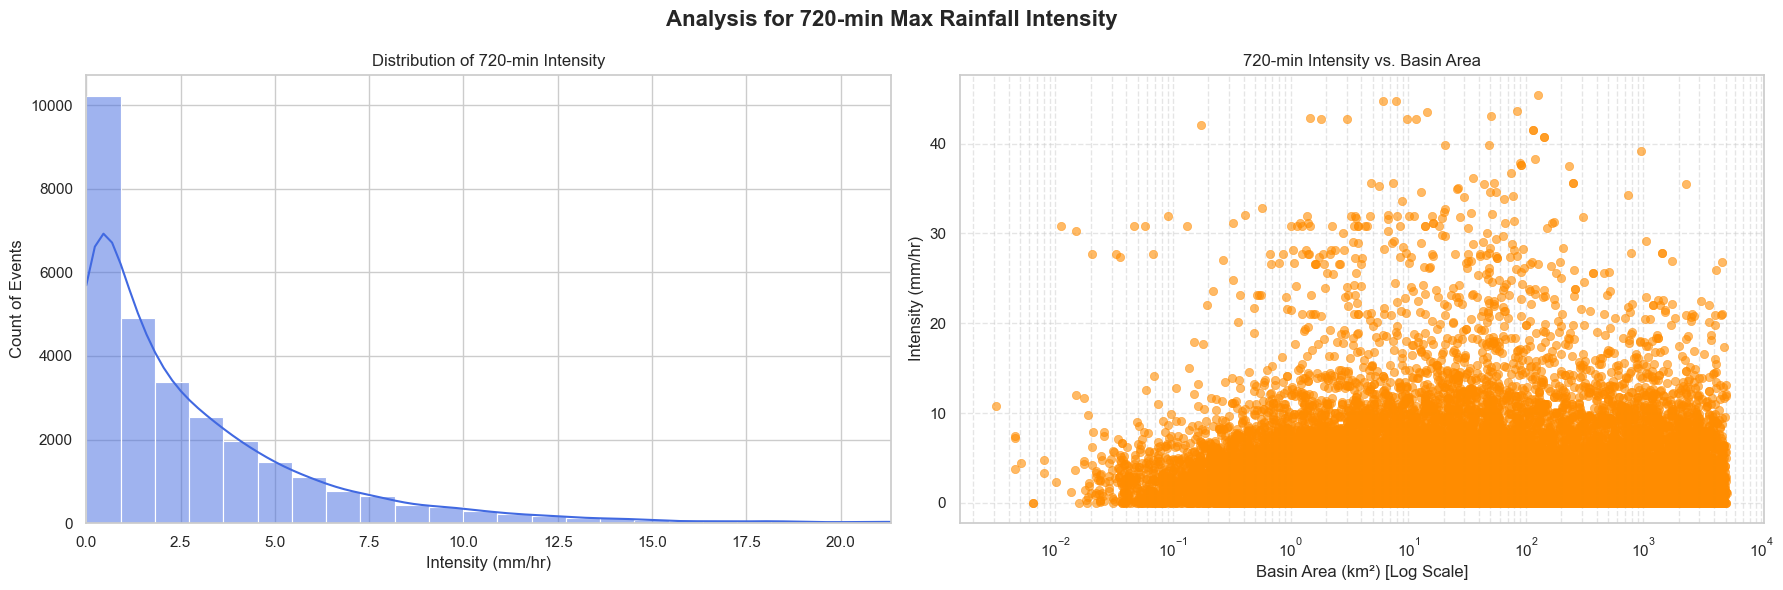

--------------------------------------------------------------------------------


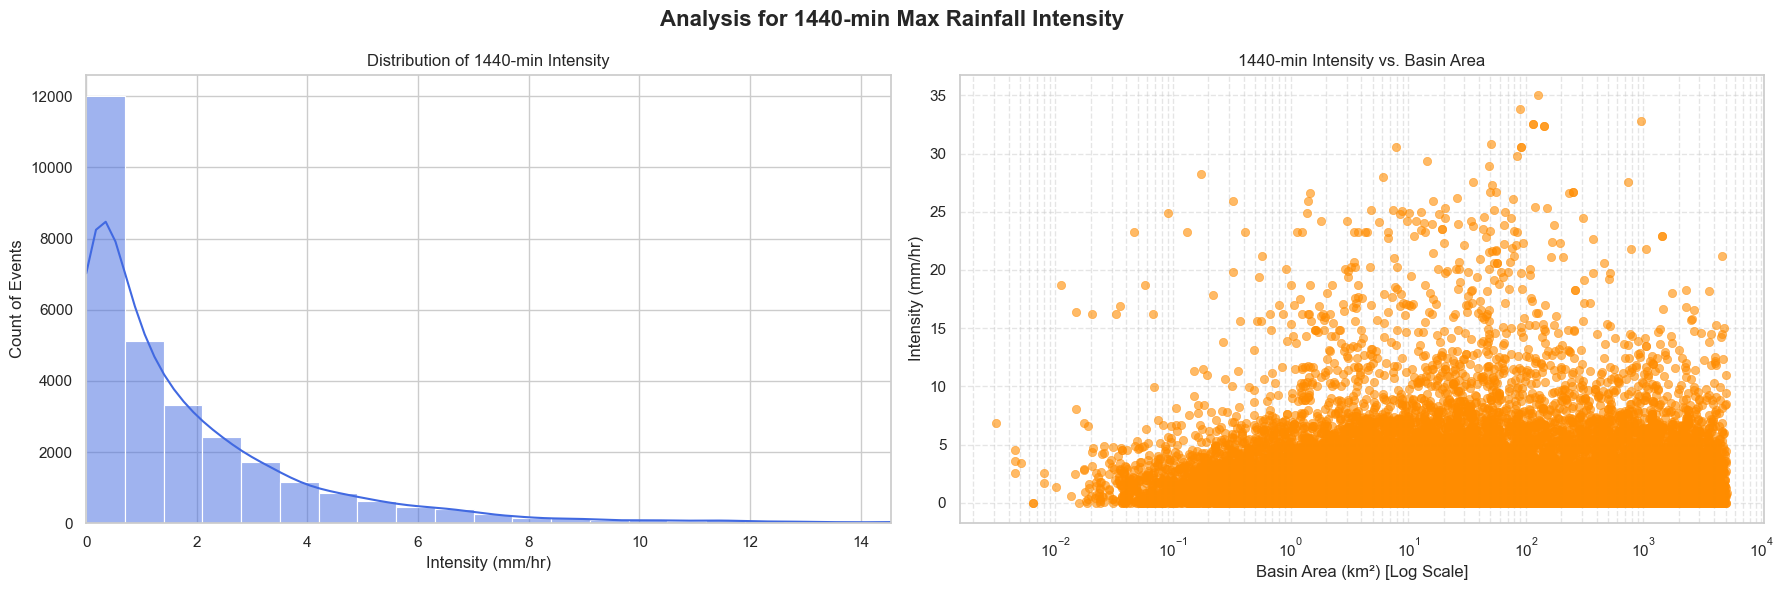

--------------------------------------------------------------------------------


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ============================================
# CONFIGURATION
# ============================================
# Set global plot style
sns.set_theme(style="whitegrid")

# The durations we calculated previously
DURATIONS = [30, 60, 120, 240, 360, 720, 1440]

# ============================================
# VISUALIZATION LOOP
# ============================================

for duration in DURATIONS:
    
    # Construct the column name dynamically
    col_name = f"{duration}_max_rainfall_intens"
    
    # Check if column exists (safety check)
    if col_name not in df_chronicle_intensities.columns:
        print(f"Skipping {duration} min: Column {col_name} not found.")
        continue
        
    # Create a figure with 2 subplots (side by side)
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Title for the entire figure
    fig.suptitle(f"Analysis for {duration}-min Max Rainfall Intensity", fontsize=16, fontweight='bold')
    
    # --- Plot 1: Distribution (Histogram + KDE) ---
    sns.histplot(
        data=df_chronicle_intensities,
        x=col_name,
        bins=50,
        kde=True,
        color='royalblue',
        ax=axes[0]
    )
    
    axes[0].set_title(f"Distribution of {duration}-min Intensity")
    axes[0].set_xlabel("Intensity (mm/hr)")
    axes[0].set_ylabel("Count of Events")
    
    # Limit x-axis to 99th percentile to hide extreme outliers
    upper_limit = df_chronicle_intensities[col_name].quantile(0.99)
    if not np.isnan(upper_limit):
        axes[0].set_xlim(0, upper_limit)
    
    # --- Plot 2: Intensity vs. Basin Area ---
    sns.scatterplot(
        data=df_chronicle_intensities, 
        x='poly_area_km2', 
        y=col_name, 
        alpha=0.6, 
        edgecolor=None,
        ax=axes[1],
        color='darkorange'
    )
    
    # Use Log Scale for X-axis (Area)
    axes[1].set_xscale('log')
    
    axes[1].set_title(f"{duration}-min Intensity vs. Basin Area")
    axes[1].set_xlabel("Basin Area (km²) [Log Scale]")
    axes[1].set_ylabel("Intensity (mm/hr)")
    axes[1].grid(True, which="both", ls="--", alpha=0.5)
    
    # Final layout adjustments
    plt.tight_layout()
    plt.show()

    print("-" * 80) # Separator line between durations

In [ ]:
STOP!

In [1]:
# ============================================
# ANALYSIS NOTEBOOK
# ============================================

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Settings
INPUT_DIR = r"D:\Development\RESEARCH\urban_flood_database\chronicle\imerg_rain_outputs"

In [2]:
# ============================================
# 1. LOAD DATA (FROM BATCHES)
# ============================================
def load_all_batches(directory):
    pattern = os.path.join(directory, "imerg_batch_*.pkl")
    files = glob.glob(pattern)
    
    if not files:
        print("No data found!")
        return pd.DataFrame()
        
    print(f"Loading {len(files)} batch files...")
    df_list = []
    for f in tqdm(files):
        try:
            df_list.append(pd.read_pickle(f))
        except Exception as e:
            print(f"Skipped {f}: {e}")
            
    return pd.concat(df_list, ignore_index=True)

# Load
df = load_all_batches(INPUT_DIR)

# Filter valid rain data
df_rain = df.dropna(subset=['imerg_matrix']).copy()
print(f"Loaded {len(df_rain)} events with rain data.")

Loading 30 batch files...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 451.68it/s]

Loaded 2992 events with rain data.


In [4]:
df_rain['imerg_matrix']

0        [[[0.0, 0.0]], [[0.0, 0.0]], [[0.0, 0.0]], [[0...
1        [[[0.33306354, 0.0024441965], [0.0, 0.0]], [[0...
2        [[[0.0, 0.39326465, 1.6282946, 0.2216488, 0.23...
3        [[[0.33306354], [0.0]], [[0.5504179], [0.0]], ...
4        [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]], [[0.0, 0....
                               ...                        
23395    [[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0...
23396    [[[0.0], [0.0]], [[0.0], [0.0]], [[0.0], [0.0]...
23397    [[[0.037309352, 0.015930934]], [[0.044569004, ...
23398    [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
23399    [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]], [[0.0, 0....
Name: imerg_matrix, Length: 23358, dtype: object

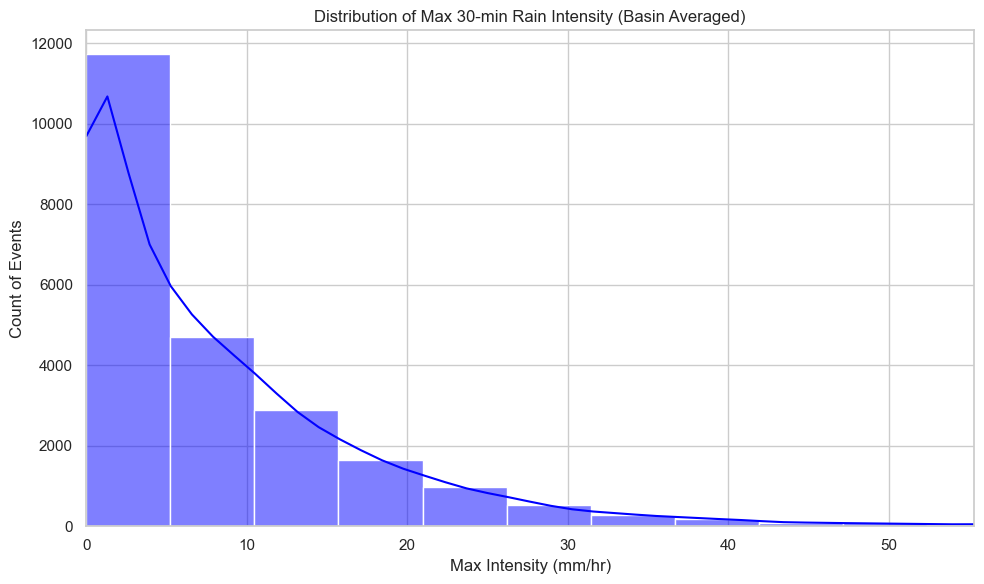

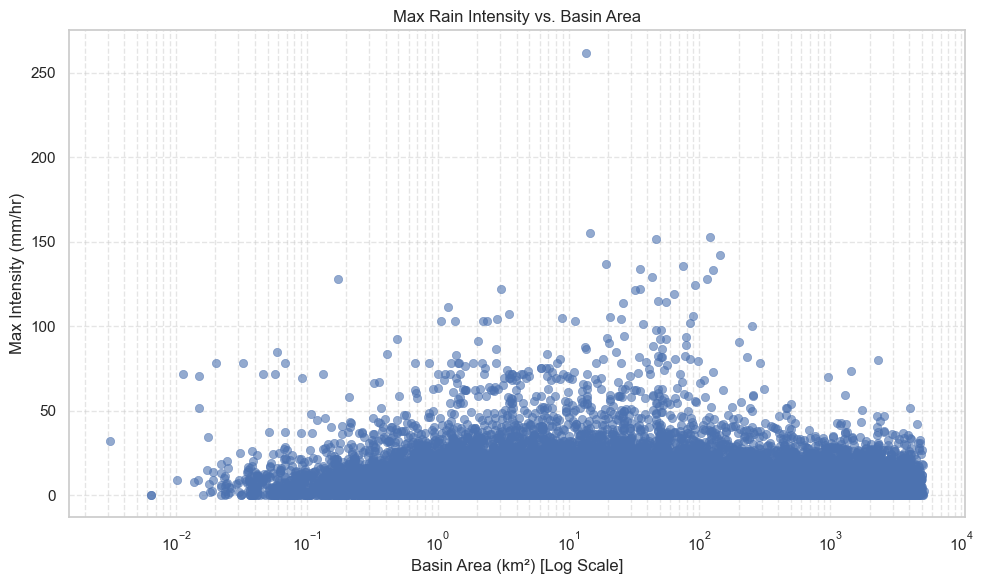

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_theme(style="whitegrid")

# --- Plot 1: Distribution of Max Intensity ---
plt.figure(figsize=(10, 6))

# Plot histogram with a Kernel Density Estimate (KDE) line
sns.histplot(df_analysis['max_intensity_mm_hr'], bins=50, kde=True, color='blue')

plt.title("Distribution of Max 30-min Rain Intensity (Basin Averaged)")
plt.xlabel("Max Intensity (mm/hr)")
plt.ylabel("Count of Events")

# Limit x-axis to 99th percentile to hide extreme outliers and make the plot readable
upper_limit = df_analysis['max_intensity_mm_hr'].quantile(0.99)
plt.xlim(0, upper_limit)

plt.tight_layout()
plt.show()

# --- Plot 2: Max Intensity vs. Basin Area ---
plt.figure(figsize=(10, 6))

# Scatter plot
sns.scatterplot(
    data=df_analysis, 
    x='poly_area_km2', 
    y='max_intensity_mm_hr', 
    alpha=0.6, 
    edgecolor=None
)

# Use Log Scale for X-axis (Area spans multiple orders of magnitude)
plt.xscale('log')

plt.title("Max Rain Intensity vs. Basin Area")
plt.xlabel("Basin Area (km²) [Log Scale]")
plt.ylabel("Max Intensity (mm/hr)")

plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

Extracting rain features...


100%|██████████████████████████████████████████████████████████████████████████| 23358/23358 [00:04<00:00, 4995.58it/s]



--- FEATURES READY ---
   event_id  rain_total_accum_mean  rain_max_hourly_intensity  \
0       296              35.645123                   4.568446   
1       297              40.515373                   5.905882   
2       298               6.444513                   1.239642   
3       299              40.515373                   5.905882   
4       300              39.362076                  20.037289   

   rain_duration_hours  rain_peak_single_pixel      PFDI  poly_area_km2  
0                 13.5                4.568446  2.117765      17.807278  
1                 13.5                5.905882  0.012133      29.694248  
2                  6.0                6.189751  0.000933    1754.314154  
3                 13.5                5.905882  0.052305      11.730829  
4                  2.0               23.829054  0.002881     105.597815  


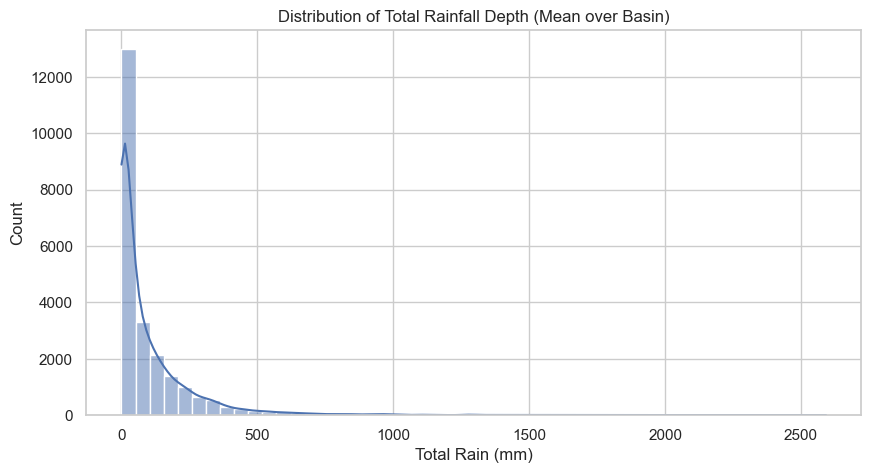

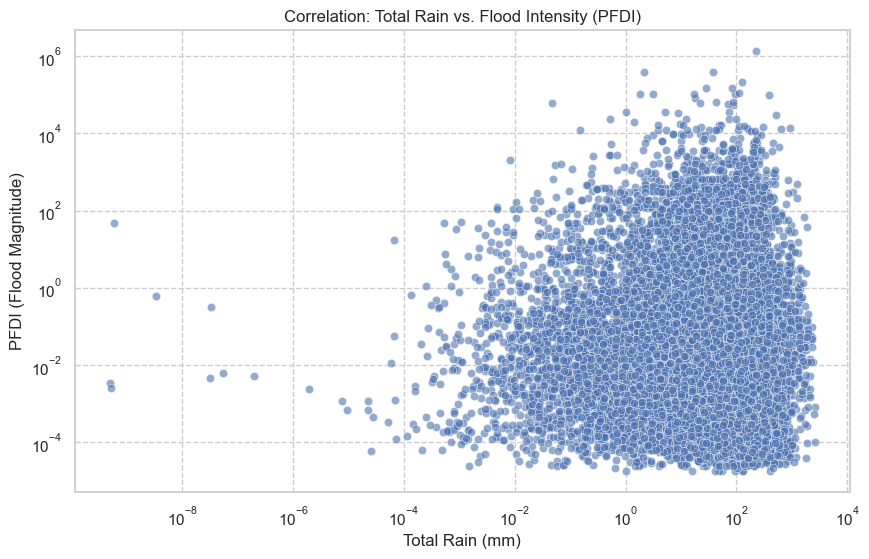

Correlation Matrix:
                           rain_total_accum_mean  rain_max_hourly_intensity  \
rain_total_accum_mean                   1.000000                   0.800583   
rain_max_hourly_intensity               0.800583                   1.000000   
PFDI                                   -0.000767                  -0.003218   

                               PFDI  
rain_total_accum_mean     -0.000767  
rain_max_hourly_intensity -0.003218  
PFDI                       1.000000  


In [7]:
# ============================================
# 2. FEATURE EXTRACTION (The Important Part)
# ============================================
# Raw matrices are hard to analyze. Let's convert them to single numbers (Scalars).

stats_list = []

print("Extracting rain features...")
for idx, row in tqdm(df_rain.iterrows(), total=len(df_rain)):
    
    matrix = row['imerg_matrix'] # Shape: (Time, Y, X)
    mask = row['imerg_mask']     # Shape: (Y, X)
    
    # Safety check for empty or broken arrays
    if not isinstance(matrix, np.ndarray) or matrix.size == 0:
        continue

    # A. BASIN AVERAGE HYETOGRAPH (Time Series)
    # We only care about pixels INSIDE the basin (mask == 1)
    # Boolean indexing allows us to select only relevant pixels across all time steps
    # matrix[:, mask==1] -> Shape becomes (Time Steps, N_Pixels)
    basin_pixels_over_time = matrix[:, mask == 1]
    
    if basin_pixels_over_time.size == 0:
        # Mask might be empty (no pixels center in polygon)
        avg_hyetograph = np.zeros(matrix.shape[0])
        max_hyetograph = np.zeros(matrix.shape[0])
    else:
        avg_hyetograph = np.nanmean(basin_pixels_over_time, axis=1) # Average rain per hour
        max_hyetograph = np.nanmax(basin_pixels_over_time, axis=1)  # Max rain per hour (peak intensity)

    # B. CALCULATE SCALAR METRICS
    features = {
        'event_id': row['event_id'],
        
        # Volume Metrics
        'rain_total_accum_mean': np.sum(avg_hyetograph), # Total rain depth (mm)
        'rain_max_hourly_intensity': np.max(avg_hyetograph), # Peak intensity (mm/hr)
        
        # Time Metrics
        # Find duration where rain > 0.1 mm/hr
        'rain_duration_hours': np.sum(avg_hyetograph > 0.1) * 0.5, # Assuming 30min steps
        
        # Spatial Metrics
        # Max rain recorded in ANY single pixel during the WHOLE event
        'rain_peak_single_pixel': np.max(matrix) if matrix.size > 0 else 0
    }
    
    stats_list.append(features)

# Create a clean Stats DataFrame
df_stats = pd.DataFrame(stats_list)

# Merge back with original metadata (like PFDI) if needed
# Assuming 'PFDI' is in the loaded pkl, if not, you merge with original dataset
if 'PFDI' in df_rain.columns:
    df_stats = df_stats.merge(df_rain[['event_id', 'PFDI', 'poly_area_km2']], on='event_id')

print("\n--- FEATURES READY ---")
print(df_stats.head())

# ============================================
# 3. ANALYSIS & PLOTS
# ============================================

# A. Histogram of Rain Depth
plt.figure(figsize=(10, 5))
sns.histplot(df_stats['rain_total_accum_mean'], bins=50, kde=True)
plt.title("Distribution of Total Rainfall Depth (Mean over Basin)")
plt.xlabel("Total Rain (mm)")
plt.show()

# B. The Golden Question: Rain vs. Flood (PFDI)
if 'PFDI' in df_stats.columns:
    plt.figure(figsize=(10, 6))
    
    # Use log scale because floods vary wildly
    sns.scatterplot(data=df_stats, x='rain_total_accum_mean', y='PFDI', alpha=0.6)
    
    plt.title("Correlation: Total Rain vs. Flood Intensity (PFDI)")
    plt.xlabel("Total Rain (mm)")
    plt.ylabel("PFDI (Flood Magnitude)")
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True, which="both", ls="--")
    plt.show()
    
    # Simple Correlation
    corr = df_stats[['rain_total_accum_mean', 'rain_max_hourly_intensity', 'PFDI']].corr()
    print("Correlation Matrix:")
    print(corr)